# Shifting moons

In this notebook we begin to experiment with the shifting moons' dataset. We obtain a procedure to rotate the domain and write a simple code to fit an MLP to an unrotated dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from IPython.display import HTML
from celluloid import Camera

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [3]:
def rotation_matrix(angle):
    """
    Create a rotation matrix that rotates the
    space 'angle'-radians.
    """
    R = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    return R

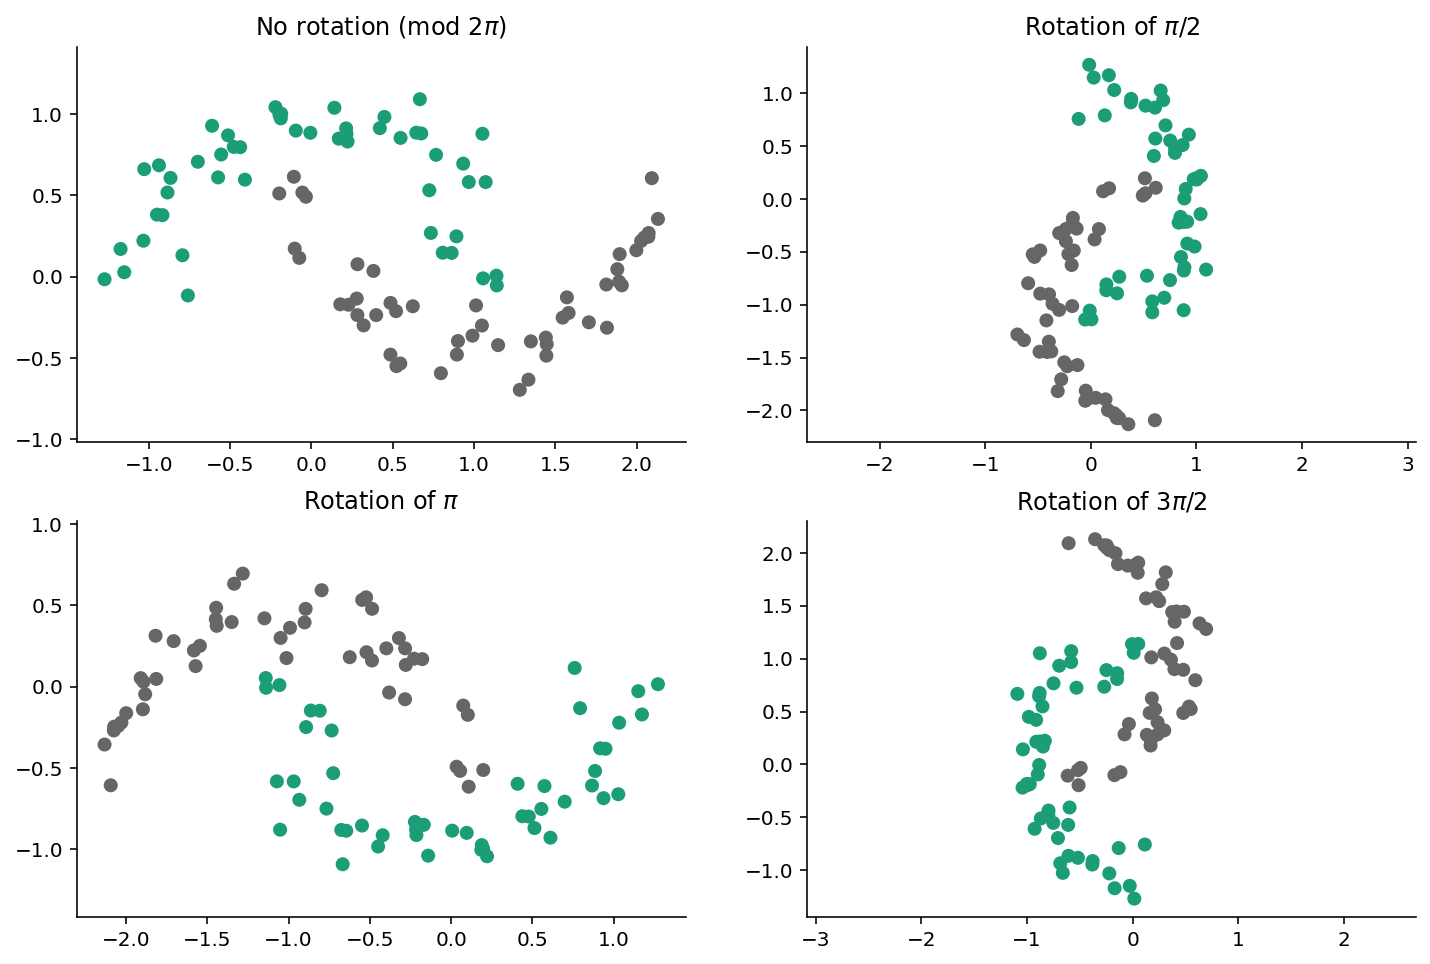

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()

X, y = make_moons(n_samples=100, noise=0.12, random_state=314)
ax[0].scatter(*X.T, c=y, cmap="Dark2")
ax[0].axis("equal")
ax[0].set_title("No rotation (mod $2\pi$)")


rotations = [np.pi/2, np.pi, 3 * np.pi / 2]
labels = ["$\pi/2$", "$\pi$", "$3\pi/2$"]
for i, (rot, lab) in enumerate(zip(rotations, labels)):
    R = rotation_matrix(rot)
    X_rot = np.einsum("ni,ij->nj", X, R)
    ax[i+1].scatter(*X_rot.T, c=y, cmap="Dark2")
    ax[i+1].axis("equal");
    ax[i+1].set_title(f"Rotation of {lab}")

# The settings

In this setting, we observe a new batch of datapoints at each timestep. Each batch is rotated clockwise in a fully-deterministic manner.

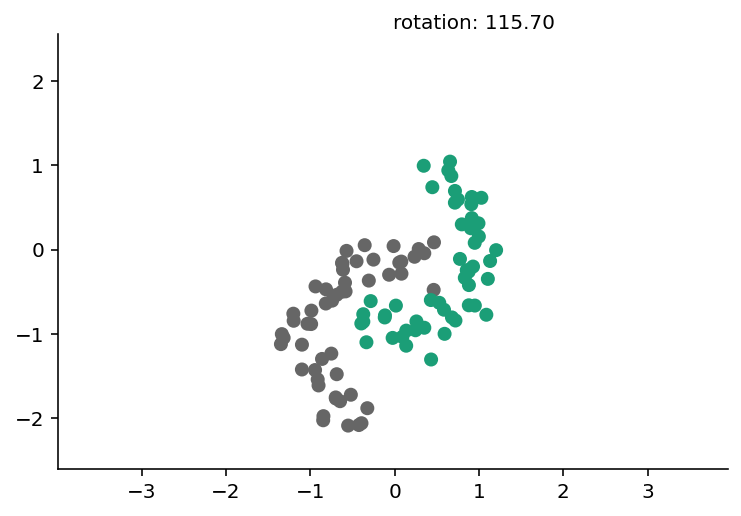

In [5]:
fig, ax = plt.subplots()
camera = Camera(fig)

for _ in np.linspace(0, 2 * np.pi, 100):
    rad = np.random.uniform(low=0, high=2 * np.pi)
    n_samples = np.random.randint(20, 200)
    X, y = make_moons(n_samples=n_samples, noise=0.15)
    R = rotation_matrix(rad)
    X_rot = np.einsum("ni,ij->nj", X, R)
    
    plt.scatter(*X_rot.T, c=y, cmap="Dark2")
    plt.axis("equal")
    deg = rad * 180 / np.pi
    ax.text(0.5, 1.01, f"rotation: {deg:0.2f}", transform=ax.transAxes)
    camera.snap()

animation = camera.animate(interval=80)
HTML(animation.to_html5_video())
animation.save("batch-random-rotating-moons.mp4", dpi=200)

## Setting 2

The datapoints are transformed clockwise and we observe obe datapoint at each step

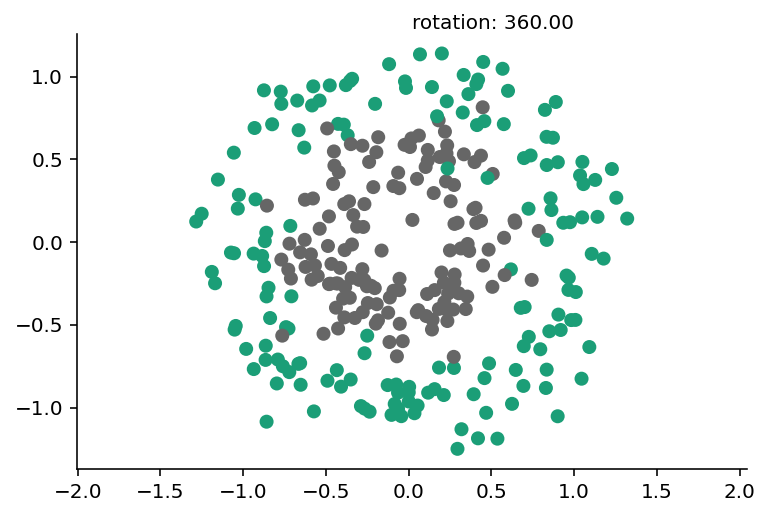

In [20]:
fig, ax = plt.subplots()
camera = Camera(fig)

X_full, y_full = [], []
for rad in np.linspace(0, 2 * np.pi, 300):
    n_samples = 2
    ix_sample = np.random.choice(2)
    X, y = make_moons(n_samples=n_samples, noise=0.15)
    R = rotation_matrix(rad)
    X_rot = np.einsum("ni,ij->nj", X, R)
    
    X_full.append(X_rot[ix_sample])
    y_full.append(y[ix_sample])
    
    plt.scatter(*np.asarray(X_full).T, c=y_full, cmap="Dark2")
    plt.axis("equal")
    deg = rad * 180 / np.pi
    ax.text(0.5, 1.01, f"rotation: {deg:0.2f}", transform=ax.transAxes)
    camera.snap()

animation = camera.animate(interval=30)
HTML(animation.to_html5_video())
animation.save("rotating-moons-clockwise.mp4", dpi=200)

## Setting 3

The datapoints are rotated randomly and we observe obe datapoint at each step

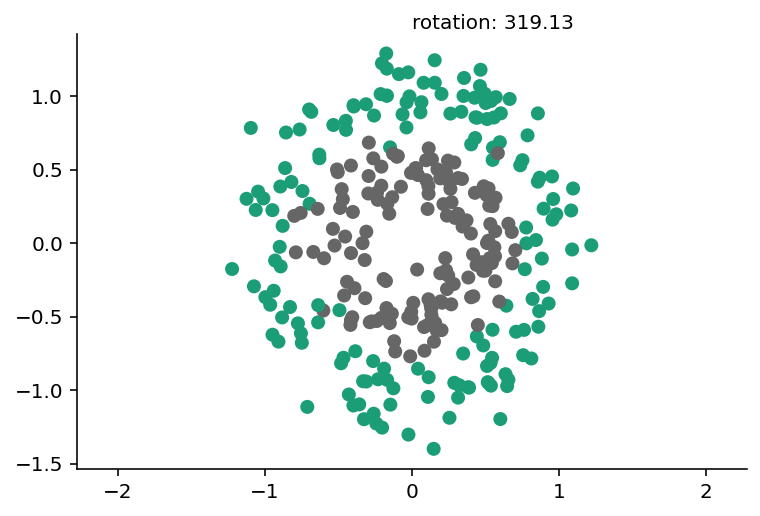

In [7]:
fig, ax = plt.subplots()
camera = Camera(fig)

X_full, y_full = [], []
for _ in np.linspace(0, 2 * np.pi, 300):
    rad = np.random.uniform(low=0, high=2 * np.pi)
    n_samples = 2
    ix_sample = np.random.choice(2)
    X, y = make_moons(n_samples=n_samples, noise=0.15)
    R = rotation_matrix(rad)
    X_rot = np.einsum("ni,ij->nj", X, R)
    
    X_full.append(X_rot[ix_sample])
    y_full.append(y[ix_sample])
    
    plt.scatter(*np.asarray(X_full).T, c=y_full, cmap="Dark2")
    plt.axis("equal")
    deg = rad * 180 / np.pi
    ax.text(0.5, 1.01, f"rotation: {deg:0.2f}", transform=ax.transAxes)
    camera.snap()

animation = camera.animate(interval=30)
HTML(animation.to_html5_video())
animation.save("rotating-moons-random.mp4", dpi=200)

## First attempt

We could model this problem as either a **domain shift** problem or a **source component shift** problem. First, let us consider the problem at hand: we the moons dataset. We could have a couple of options for this problem


1. We sequentially observe new points in an online manner and, at each timestep, we seek to predict the position of newly-arrived datapoints. These newly-observed datapoints are sampled from the typical moon's dataset and are then rotated from a dirichlet distribution that samples from a collection of possible rotations.
2. We observe a batch of $N_1$ datapoints in a train set $\mathcal{D}_\text{train}$ with rotation sampled from a dirichlet distibution and, $N_2$ datapoints in a test set $\mathcal{D}_\text{test}$ with rotation sampled from a dirichlet distribution. The goal is to obtain a model in $\mathcal{D}_\text{train}$ and accurately predict on $\mathcal{D}_\text{test}$.

In [8]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [9]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(30)(x))
        x = nn.relu(nn.Dense(30, name="last_layer")(x))
        x = nn.Dense(1)(x)
        x = nn.sigmoid(x)
        return x

In [10]:
X, y = make_moons(n_samples=100, noise=0.12, random_state=314)

In [11]:
def make_mse_func(x_batched, y_batched):
  def mse(params):
    # Define the squared loss for a single pair (x,y)
    def squared_error(x, y):
      pred = model.apply(params, x)
      return jnp.inner(y-pred, y-pred)/2.0
    # We vectorize the previous to compute the average of the loss on all samples.
    return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)
  return jax.jit(mse) # And finally we jit the result.

In [12]:
loss = make_mse_func(X, y)

In [13]:
model = MLP()
batch = jnp.ones((1, 2))
key = jax.random.PRNGKey(314)
params = model.init(key, batch)

alpha = 0.1
tx = optax.adam(learning_rate=alpha)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss)

In [14]:

for i in range(201):
  loss_val, grads = loss_grad_fn(params)
  updates, opt_state = tx.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  if i % 50 == 0:
    print('Loss step {}: '.format(i), loss_val)


Loss step 0:  0.09935955
Loss step 50:  0.00034957158
Loss step 100:  2.6696148e-06
Loss step 150:  5.7818403e-07
Loss step 200:  2.9943575e-07


In [15]:
pred_map = jax.vmap(model.apply, (None, 1))
pred_map = jax.vmap(pred_map, (None, 2))

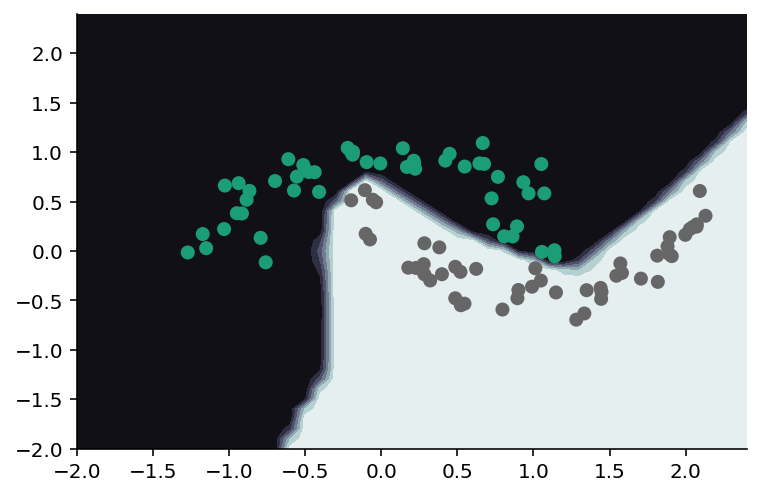

In [16]:
X_grid = jnp.mgrid[-2:2.5:0.1, -2:2.5:0.1]
Z = jnp.einsum("ijn->ji", pred_map(params, X_grid))

plt.contourf(*X_grid, Z, cmap="bone")
plt.scatter(*X.T, c=y, cmap="Dark2")

In [17]:
X_test, y_test = make_moons(n_samples=50, noise=0.12, random_state=3141)
y_test_est = model.apply(params, X_test).round().ravel()

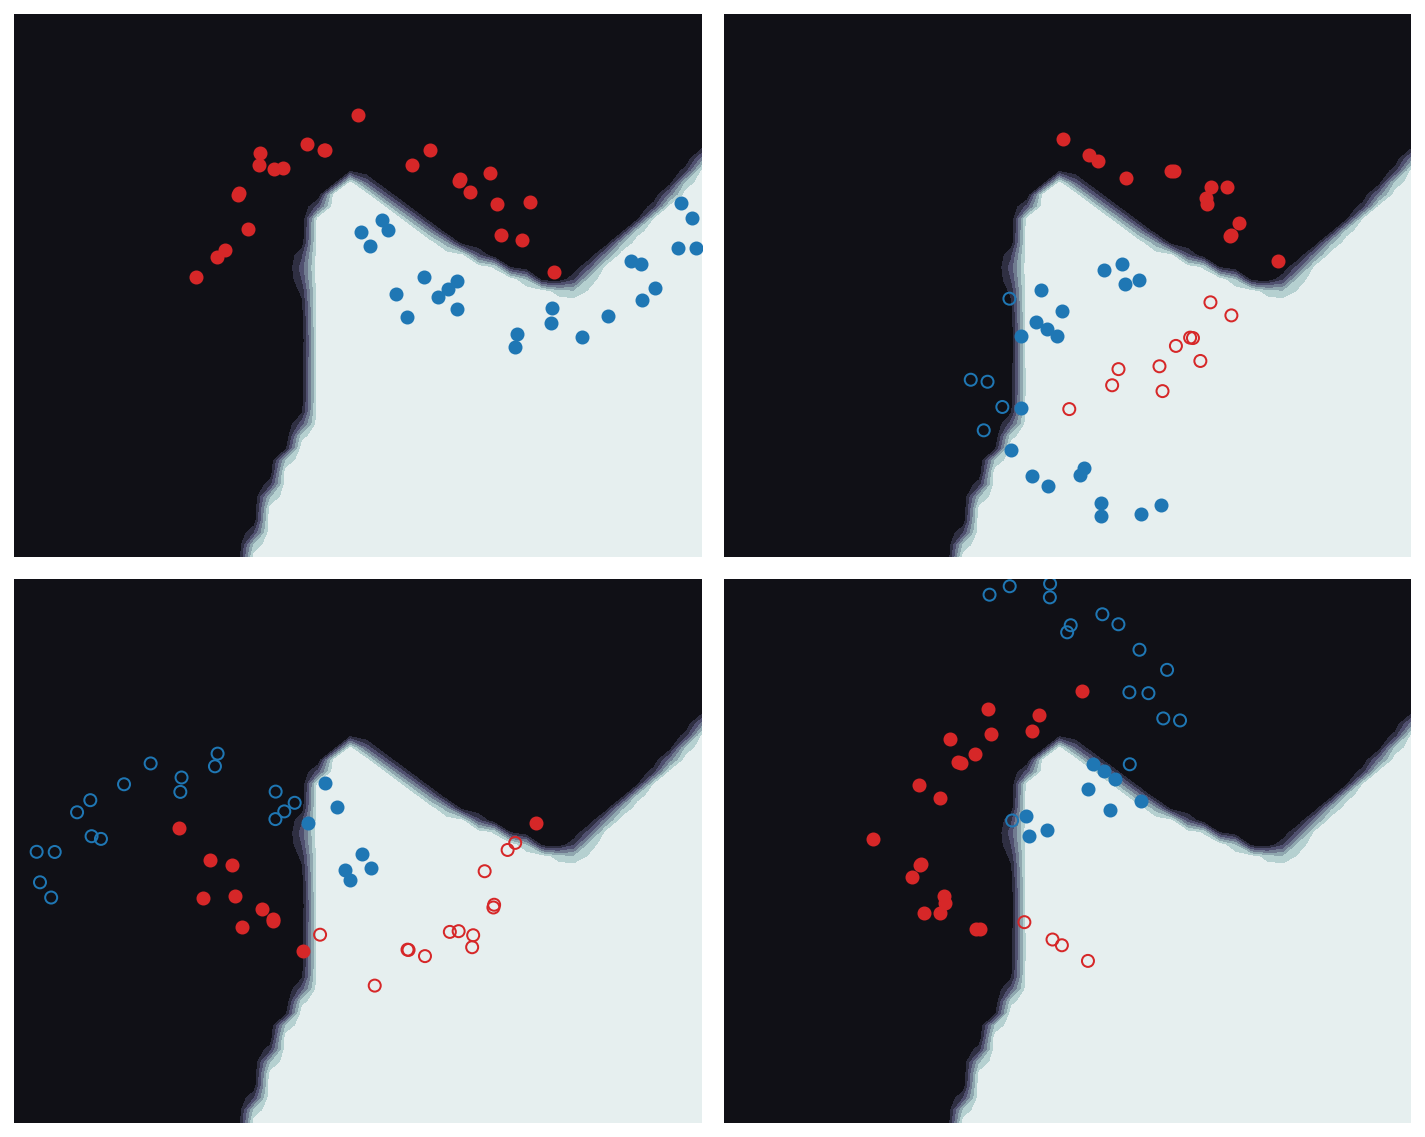

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.ravel()

rads = [0, jnp.pi / 2, jnp.pi, 3 * jnp.pi / 2]
for axi, rad  in zip(ax, rads):
    
    R = rotation_matrix(rad)
    X_test_rot = np.einsum("ni,ij->nj", X_test, R)

    y_test_est = model.apply(params, X_test_rot).round().ravel()
    
    for obs, ytrue, ypred in zip(X_test_rot, y_test, y_test_est):
        c="tab:blue" if ytrue == 1 else "tab:red"
        fill = c if ytrue == ypred else "none"
        axi.scatter(*obs, edgecolor=c, zorder=2, facecolor=fill)

    # axi.scatter(*X_test_rot.T, edgecolors=y_test_est, cmap="Dark2", zorder=2,)

    X_grid = jnp.mgrid[-2.2:2.1:0.1, -2.4:2.2:0.1]
    Z = jnp.einsum("ijn->ji", pred_map(params, X_grid))
    axi.contourf(*X_grid, Z, cmap="bone")
    axi.axis("off")
plt.tight_layout()

## References
1. https://en.wikipedia.org/wiki/Rotation_matrix